In [38]:
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Paths
scRNA_path = "/root/s3/projects/SSI/datasets/sc_reference/GSE157079_P0_adult.h5ad"
ST_path    = "/root/s3/projects/SSI/mouse_kidney/Puck_191223_19_corr_pruned_inplace_CoDi_KLD.h5ad"

def preprocess_and_umap(path, label_key, n_hvg=5000, n_pca=128):
    """Load, normalize if needed, extract HVGs, PCA, UMAP, compute metrics."""
    adata = sc.read_h5ad(path)

    # Normalization (skip if already normalized)
    if "log1p" not in adata.uns.keys():
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)

    # HVGs
    if "highly_variable" not in adata.var.keys():
        sc.pp.highly_variable_genes(adata, n_top_genes=n_hvg, subset=True)

    # Scale, PCA, neighbors, UMAP
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=n_pca, svd_solver="arpack")

    return adata

# --- Run for both datasets ---
adata_scRNA = preprocess_and_umap(scRNA_path, "clusters_mod")
adata_ST = preprocess_and_umap(ST_path, "CoDi")

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/prep

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.metrics import davies_bouldin_score, silhouette_score

# --- Extract PCA embeddings ---
X_pca_sc = adata_scRNA.obsm["X_pca"]
X_pca_st = adata_ST.obsm["X_pca"]

labels_sc = adata_scRNA.obs["clusters_mod"].astype(str).to_numpy()
labels_st = adata_ST.obs["CoDi"].astype(str).to_numpy()

# --- UMAP projection (same settings for all) ---
umap_model = umap.UMAP(n_components=2, metric="cosine", random_state=42,
                       n_neighbors=50, n_jobs=5)
scRNA_umap_pca = umap_model.fit_transform(X_pca_sc)

umap_model = umap.UMAP(n_components=2, metric="cosine", random_state=42,
                       n_neighbors=50, n_jobs=5)
ST_umap_pca = umap_model.fit_transform(X_pca_st)

umap_model = umap.UMAP(n_components=2, metric="cosine", random_state=42,
                       n_neighbors=50, n_jobs=5)
scRNA_umap_emb = umap_model.fit_transform(np.load("/root/s3/projects/SSI/mouse_kidney/GSE157079_P0_adult_SC_embeddings.png.npy"))

umap_model = umap.UMAP(n_components=2, metric="cosine", random_state=42,
                       n_neighbors=50, n_jobs=5)
ST_umap_emb = umap_model.fit_transform(np.load("/root/s3/projects/SSI/mouse_kidney/Puck_191223_19_corr_pruned_inplace_ST_embeddings.png.npy"))

# --- Compute clustering metrics ---
dbi_sc_pca = davies_bouldin_score(scRNA_umap_pca, labels_sc)
sil_sc_pca = silhouette_score(scRNA_umap_pca, labels_sc)

dbi_st_pca = davies_bouldin_score(ST_umap_pca, labels_st)
sil_st_pca = silhouette_score(ST_umap_pca, labels_st)

dbi_sc_emb = 0#davies_bouldin_score(scRNA_umap_emb, labels_sc)
sil_sc_emb = 0#silhouette_score(scRNA_umap_emb, labels_sc)

dbi_st_emb = davies_bouldin_score(ST_umap_emb, labels_st)
sil_st_emb = silhouette_score(ST_umap_emb, labels_st)

# --- Consistent color palette ---
clusters_all = np.concatenate([labels_sc, labels_st])
# Create mapping with your custom palette
unique_clusters = sorted(set(clusters_all))   # consistent ordering
cluster_palette = [
    "#1f77b4","#ff7f0e","#279e68","#d62728","#aa40fc","#aa40fc",
    "#e377c2","#b5bd61","#17becf","#aec7e8","#ffbb78","#98df8a",
    "#ff9896","#c5b0d5","#c49c94","#f7b6d2","#dbdb8d","#9edae5",
    "#ad494a","#8c6d31","#b4d2b1","#568f8b","#1d4a60","#cd7e59",
    "#ddb247","#d15252","#264653","#2a9d8f","#e9c46a","#f4a261",
    "#e76f51","#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c",
    "#fbf8cc","#fde4cf","#ffcfd2","#f1c0e8","#cfbaf0","#a3c4f3",
    "#90dbf4","#8eecf5","#8359A3","#5e503f","#33CC99","#F2C649",
    "#B94E48","#0095B7","#FF681F","#e0aaff","#FED85D","#0a0908",
    "#C32148","#98f5e1","#000000","#FFFF00"
]

# Make sure palette length ≥ number of clusters
assert len(cluster_palette) >= len(unique_clusters), "Not enough colors for all clusters!"

cluster_color_dict = {c: cluster_palette[i] for i, c in enumerate(unique_clusters)}

colors_sc_pca = [cluster_color_dict[l] for l in labels_sc]
colors_st_pca = [cluster_color_dict[l] for l in labels_st]
colors_sc_emb = [cluster_color_dict[l] for l in labels_sc]
colors_st_emb = [cluster_color_dict[l] for l in labels_st]

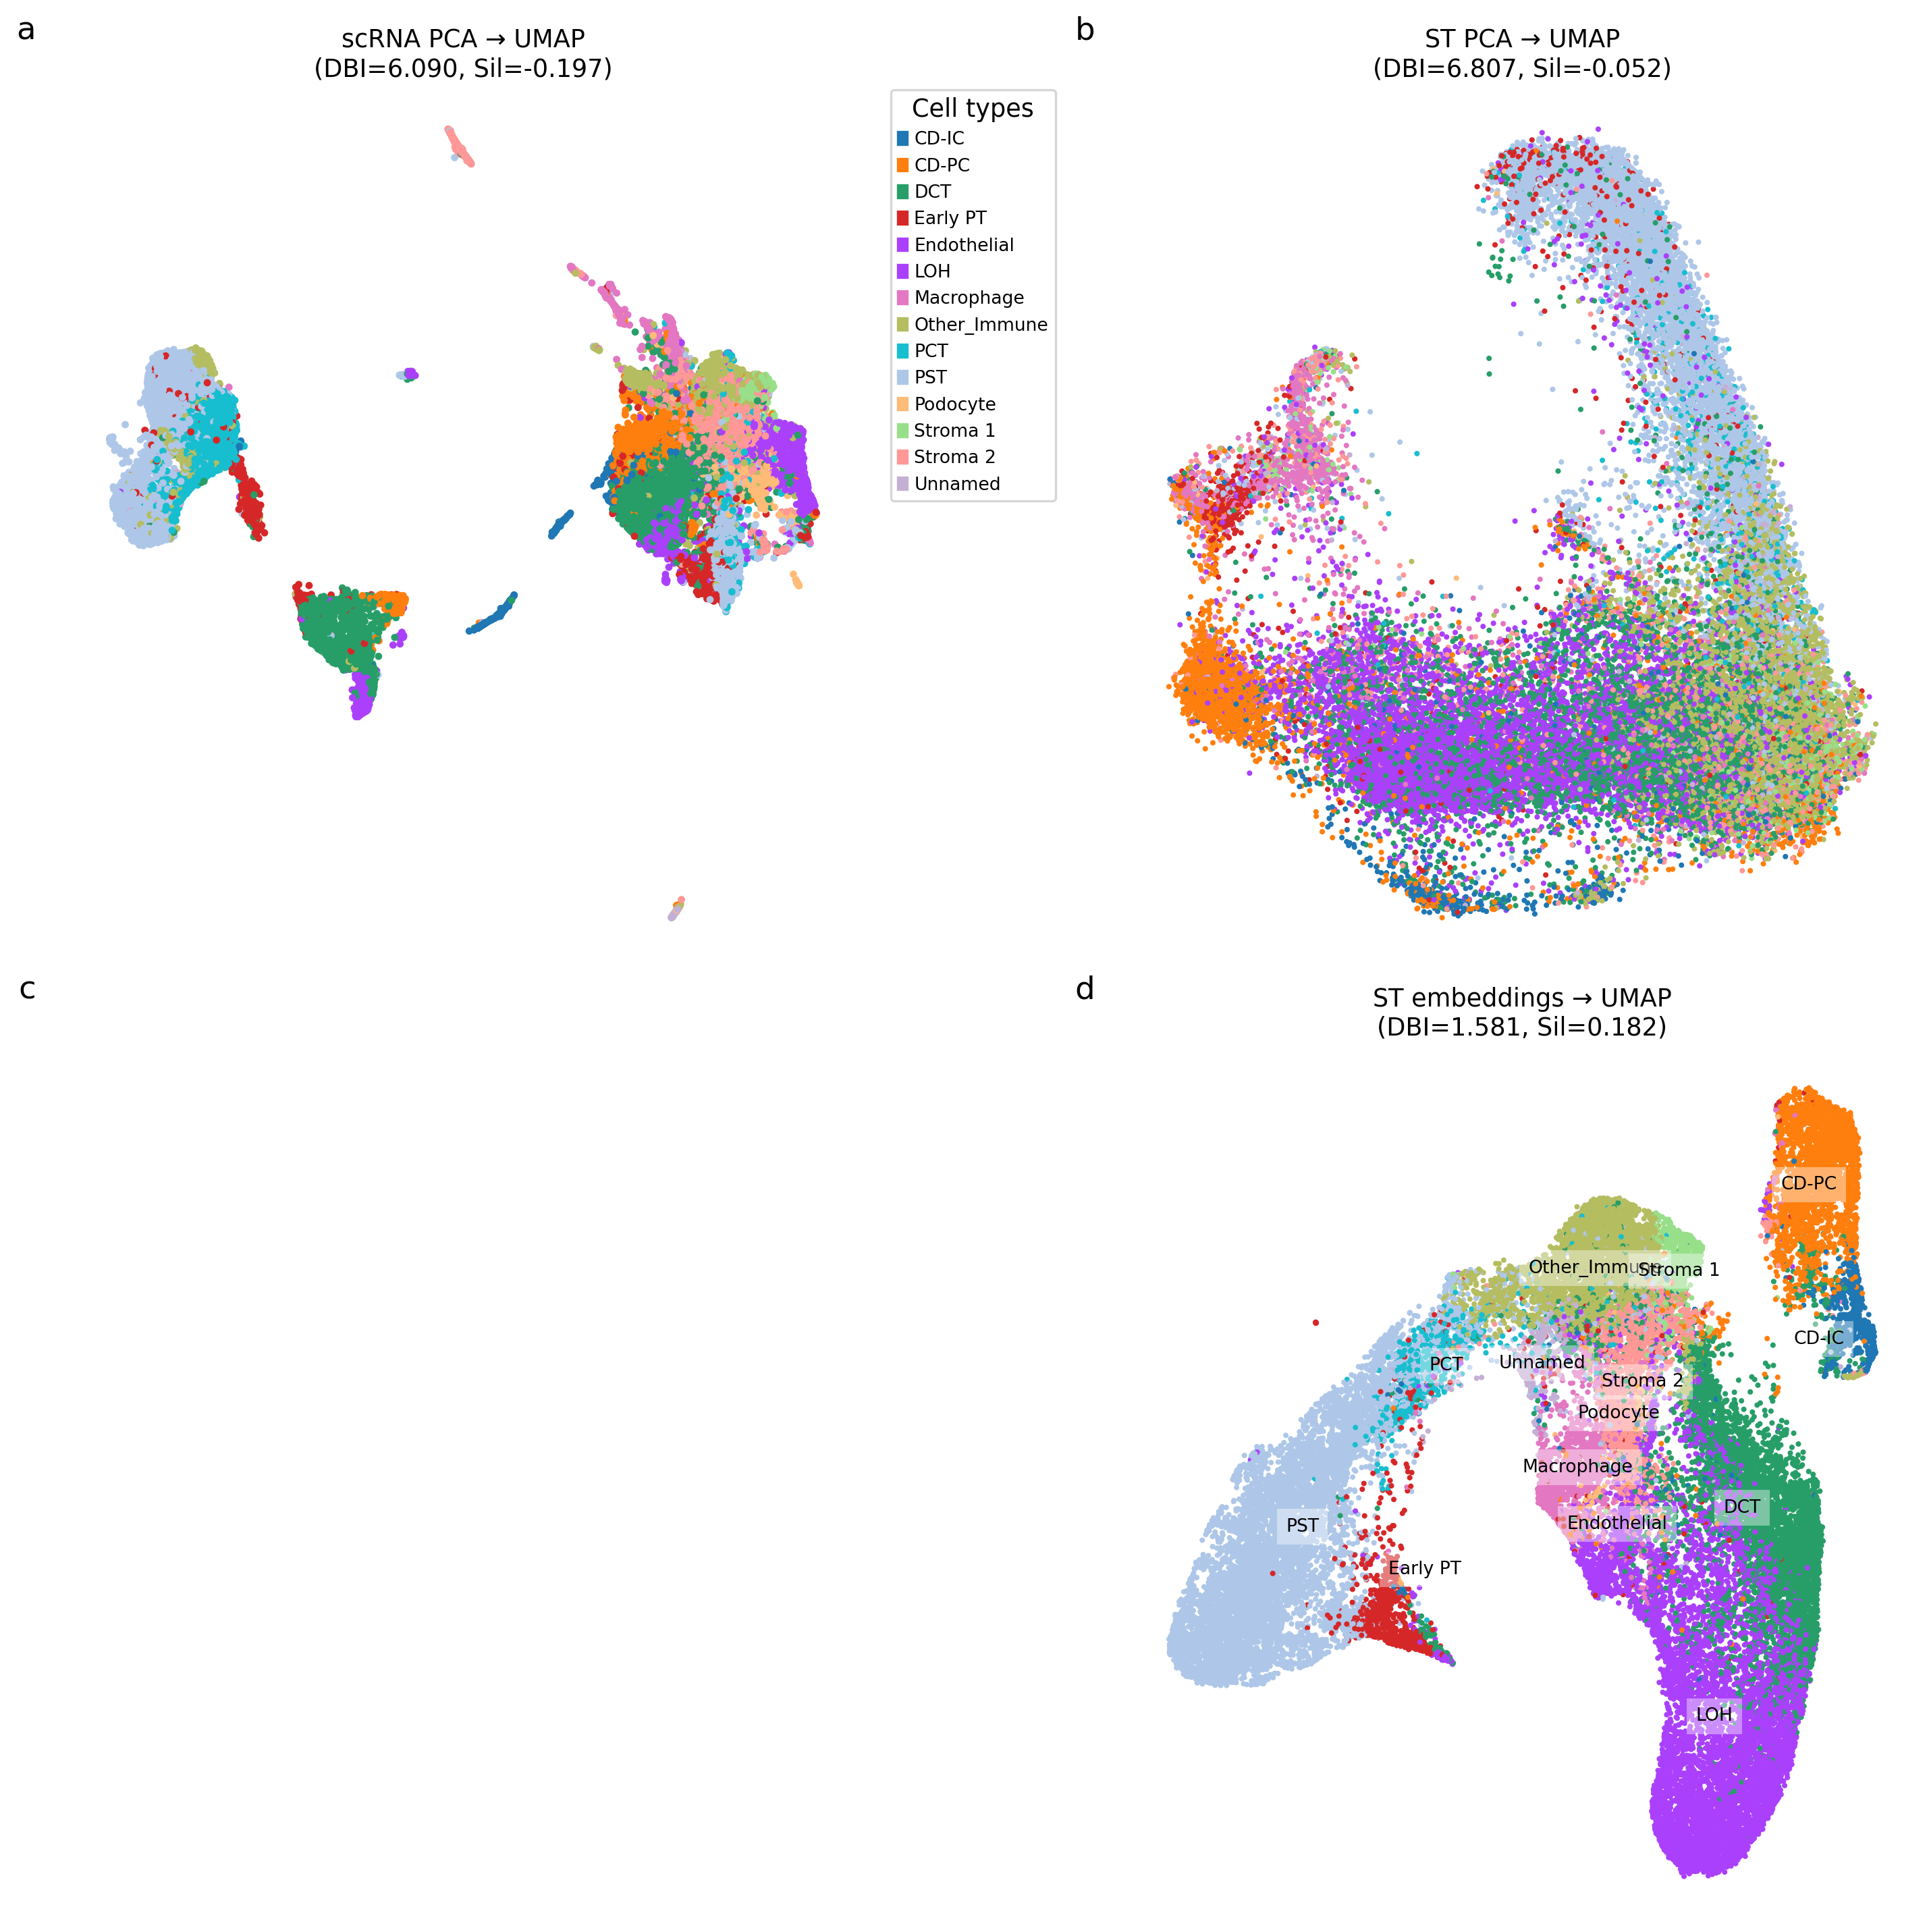

In [60]:
# --- Plot 2x2 figure ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.rcParams["font.family"] = "DejaVu Sans"
marker_size = 2
# a) scRNA PCA → UMAP
axes[0,0].scatter(scRNA_umap_pca[:,0], scRNA_umap_pca[:,1],
                  c=colors_sc_pca, s=marker_size)
axes[0,0].set_title(f"scRNA PCA → UMAP\n(DBI={dbi_sc_pca:.3f}, Sil={sil_sc_pca:.3f})")

# b) ST PCA → UMAP
axes[0,1].scatter(ST_umap_pca[:,0], ST_umap_pca[:,1],
                  c=colors_st_pca, s=marker_size)
axes[0,1].set_title(f"ST PCA → UMAP\n(DBI={dbi_st_pca:.3f}, Sil={sil_st_pca:.3f})")

# c) scRNA embedding → UMAP
# axes[1,0].scatter(scRNA_umap_emb[:,0], scRNA_umap_emb[:,1],
#                   c=colors_sc_emb, s=marker_size)
# axes[1,0].set_title(f"scRNA embeddings → UMAP\n(DBI={dbi_sc_emb:.3f}, Sil={sil_sc_emb:.3f})")

# d) ST embedding → UMAP
axes[1,1].scatter(ST_umap_emb[:,0], ST_umap_emb[:,1],
                  c=colors_st_emb, s=marker_size)
axes[1,1].set_title(f"ST embeddings → UMAP\n(DBI={dbi_st_emb:.3f}, Sil={sil_st_emb:.3f})")

# Add cluster labels to panels c and d
for ax, coords, labels in [#(axes[1,0], scRNA_umap_emb, labels_sc),
                           (axes[1,1], ST_umap_emb, labels_st)]:
    df = pd.DataFrame({"x": coords[:,0], "y": coords[:,1], "label": labels})
    for label in df["label"].unique():
        mean_x = df[df["label"] == label]["x"].mean()
        mean_y = df[df["label"] == label]["y"].mean()
        ax.text(mean_x, mean_y, str(label),
                fontsize=8, ha="center", va="center",
                bbox=dict(facecolor="white", alpha=0.4, edgecolor="none"))

# Remove ticks, grids, and frames
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Subplot labels a-d
labels = ["a","b","c","d"]
for lbl, ax in zip(labels, axes.flat):
    ax.text(-0.05, 1.05, lbl, transform=ax.transAxes,
            fontsize=14, va="bottom", ha="right")
# Show legend on a
import matplotlib.patches as mpatches

# --- after plotting panel a) ---
axes[0,0].scatter(scRNA_umap_pca[:,0], scRNA_umap_pca[:,1],
                  c=colors_sc_pca, s=5)

# Build legend handles from cluster_color_dict
handles = [mpatches.Patch(color=col, label=lab) for lab, col in cluster_color_dict.items()]
axes[0,0].legend(handles=handles,
                 bbox_to_anchor=(1.05, 1),  # place outside plot
                 loc="upper left",
                 borderaxespad=0.,
                 fontsize=8,
                 title="Cell types")

plt.tight_layout()
plt.savefig("scRNA_ST_umap_uniform.png", dpi=300, bbox_inches="tight")
plt.show()


In [33]:
len(adata_scRNA)

43636

In [31]:
len(scRNA_emb)

43629

In [61]:
import scanpy as sc
import matplotlib.pyplot as plt

# Load dataset
adata = sc.read_h5ad("/root/s3/projects/SSI/datasets/mouse_brain_visium_cell2location/synthetic_sc.h5ad")
# /root/s3/projects/SSI/datasets/stereo_seq/E16.5_E1S3_cell_bin_whole_brain_noborderct_unlog1p_pruned_inplace.h5ad
# /root/s3/projects/SSI/datasets/sc_reference/GSE157079_P0_adult.h5ad
# /root/s3/projects/SSI/datasets/slide_seq/Puck_191223_19_corr_pruned_inplace.h5ad
# /root/s3/projects/SSI/datasets/stereo_seq/E16.5_E1S3_cell_bin_whole_brain_noborderct_unlog1p_pruned_inplace.h5ad


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


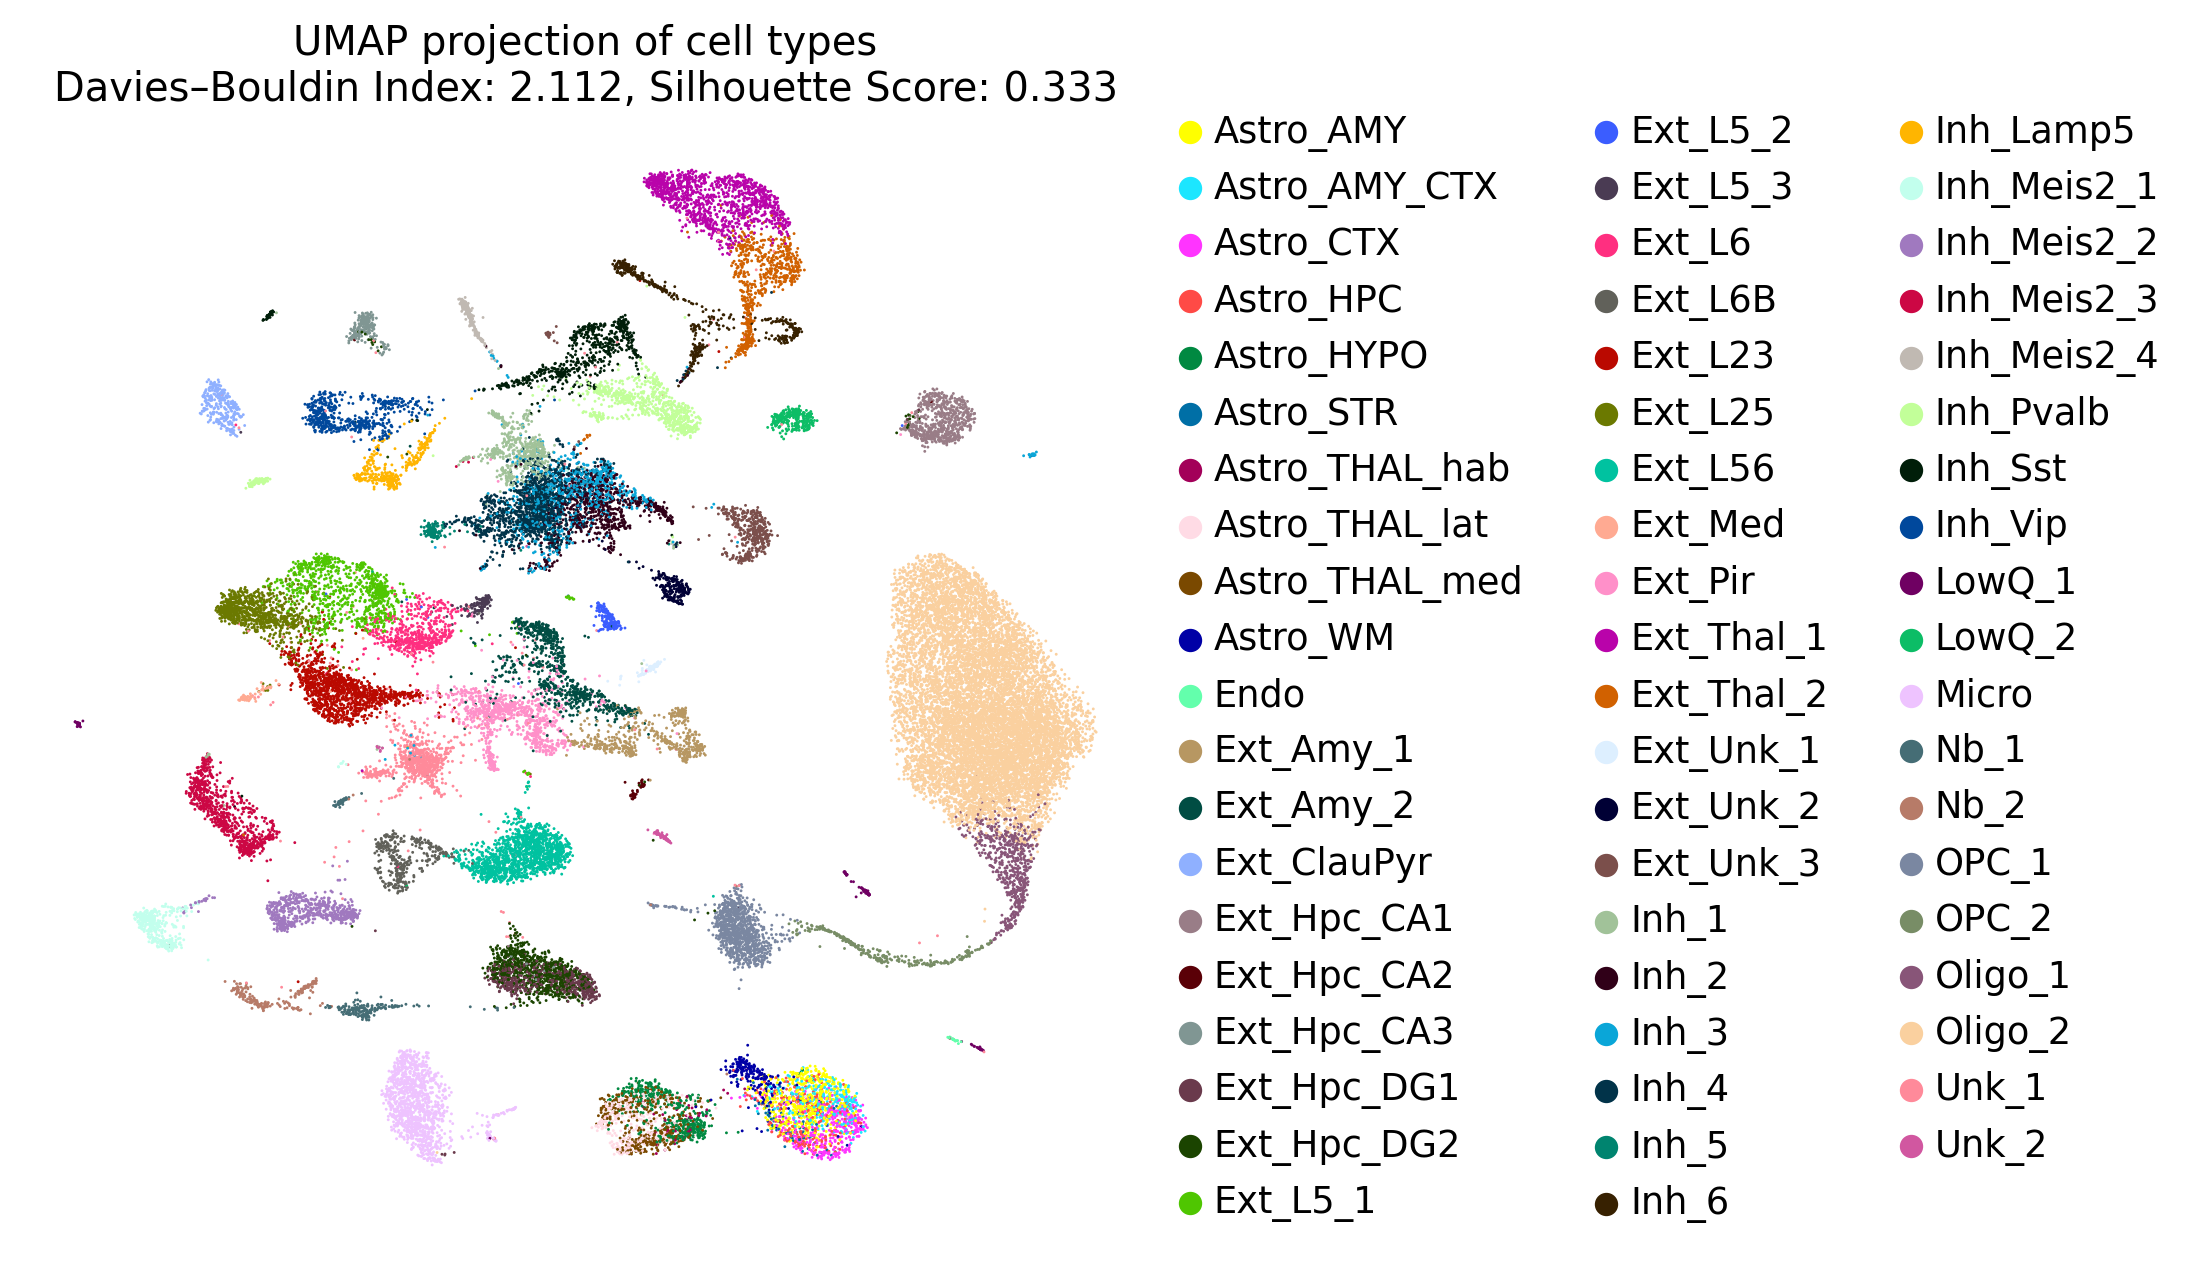

In [25]:
from sklearn.metrics import davies_bouldin_score, silhouette_score
# --- Extract embeddings and labels ---
X_umap = adata.obsm["X_umap"]
labels = adata.obs["annotation_1"].astype(str)

# --- Compute separability metrics ---
dbi = davies_bouldin_score(X_umap, labels)
silhouette = silhouette_score(X_umap, labels)

# --- Plot with annotated scores ---
sc.set_figure_params(scanpy=True, dpi=120, fontsize=12, figsize=(6,6), dpi_save=300, vector_friendly=True)
plt.rcParams["font.family"] = "DejaVu Sans"  # Arial-like

sc.pl.umap(
    adata,
    color="annotation_1",
    frameon=False,
    title="",        # We'll add our own title
    show=False
)

plt.xlabel("")
plt.ylabel("")

# Custom title with scores
plt.title(f"UMAP projection of cell types\n"
          f"Davies–Bouldin Index: {dbi:.3f}, Silhouette Score: {silhouette:.3f}",
          fontsize=12)

# plt.savefig("UMAP_with_scores.png", dpi=200, bbox_inches="tight")
plt.show()